ℓ1 Total Variation Denoising

In [2]:
from xdesign import SiemensStar, discrete_phantom

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot
from scico.examples import spnoise
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
from scipy.ndimage import median_filter
plot.config_notebook_plotting()

In [3]:
N = 256  # image size
phantom = SiemensStar(16)
x_gt = snp.pad(discrete_phantom(phantom, N - 16), 8)
x_gt = 0.5 * x_gt / x_gt.max()
y = spnoise(x_gt, 0.5)

Denoise with median filtering.

In [4]:
x_med = median_filter(y, size=(5, 5))

Denoise with ℓ1 total variation.

In [5]:
λ = 1.5e0
g_loss = loss.Loss(y=y, f=functional.L1Norm())
g_tv = λ * functional.L21Norm()
# The append=0 option makes the results of horizontal and vertical finite
# differences the same shape, which is required for the L21Norm.
C = linop.FiniteDifference(input_shape=x_gt.shape, append=0)

In [10]:
solver = ADMM(
    f=None,
    g_list=[g_loss, g_tv],
    C_list=[linop.Identity(input_shape=y.shape), C],
    rho_list=[5e0, 5e0],
    x0=y,
    maxiter=100000,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-3, "maxiter": 20}),
    itstat_options={"display": True, "period": 10},
)

In [11]:
print(f"Solving on {device_info()}\n")
x_tv = solver.solve()
hist = solver.itstat_object.history(transpose=True)

Solving on CPU

Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  1.04e-02  4.255e+04  1.412e+02  6.786e+02      0  0.000e+00
  10  1.23e-01  1.912e+04  1.251e+01  3.873e+01      8  9.019e-04
  20  2.03e-01  1.912e+04  1.972e+00  7.596e+00      5  7.518e-04
  30  2.72e-01  1.912e+04  8.768e-01  2.884e+00      4  5.522e-04
  40  3.41e-01  1.912e+04  4.938e-01  1.630e+00      3  7.054e-04
  50  4.30e-01  1.913e+04  3.290e-01  1.052e+00      2  9.774e-04
  60  4.96e-01  1.913e+04  2.393e-01  6.357e-01      2  8.947e-04
  70  5.67e-01  1.913e+04  1.950e-01  5.180e-01      1  9.686e-04
  80  6.26e-01  1.913e+04  1.588e-01  2.012e-01      1  9.221e-04
  90  6.84e-01  1.913e+04  1.339e-01  1.767e-01      1  8.779e-04
 100  7.44e-01  1.913e+04  1.194e-01  1.559e-01      1  7.987e-04
 110  8.46e-01  1.913e+04  1.054e-01  1.453e-01      1  7.290e-04
 120  9.31e-01  1.913e+04  9.546e-02  1.306e-01      1  6.61

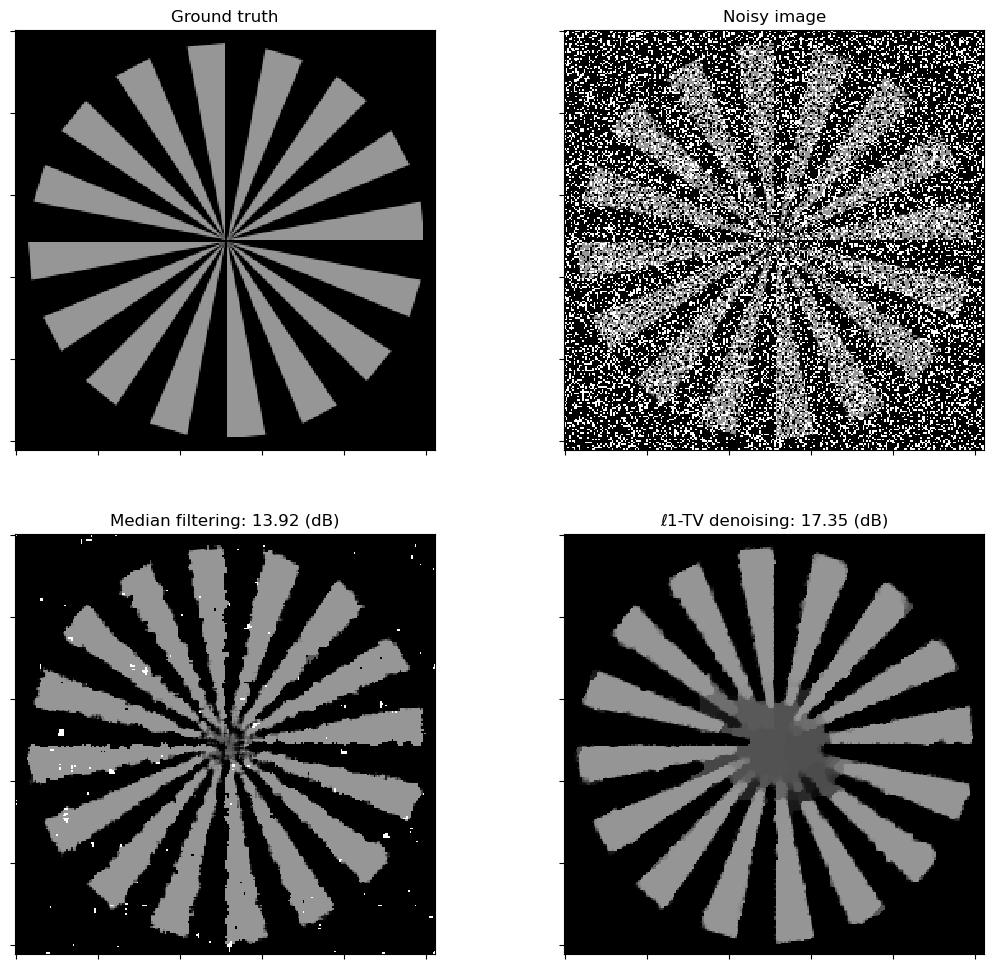

In [12]:
plt_args = dict(norm=plot.matplotlib.colors.Normalize(vmin=0, vmax=1.0))
fig, ax = plot.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(13, 12))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0, 0], **plt_args)
plot.imview(y, title="Noisy image", fig=fig, ax=ax[0, 1], **plt_args)
plot.imview(
    x_med,
    title=f"Median filtering: {metric.psnr(x_gt, x_med):.2f} (dB)",
    fig=fig,
    ax=ax[1, 0],
    **plt_args,
)
plot.imview(
    x_tv,
    title=f"ℓ1-TV denoising: {metric.psnr(x_gt, x_tv):.2f} (dB)",
    fig=fig,
    ax=ax[1, 1],
    **plt_args,
)
fig.show()

Plot convergence statistics.

In [13]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
plot.plot(
    hist.Objective,
    title="Objective function",
    xlbl="Iteration",
    ylbl="Functional value",
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist.Prml_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
    fig=fig,
    ax=ax[1],
)
fig.show()

: 

Total Variation Denoising (ADMM)
https://scico.readthedocs.io/en/latest/examples/denoise_tv_admm.html

In [1]:
from xdesign import SiemensStar, discrete_phantom

import scico.numpy as snp
import scico.random
from scico import functional, linop, loss, plot
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

In [2]:
N = 256  # image size
phantom = SiemensStar(16)
x_gt = snp.pad(discrete_phantom(phantom, N - 16), 8)
x_gt = x_gt / x_gt.max()

In [3]:
σ = 0.75  # noise standard deviation
noise, key = scico.random.randn(x_gt.shape, seed=0)
y = x_gt + σ * noise

Denoise with isotropic total variation.

In [4]:
λ_iso = 1.4e0
f = loss.SquaredL2Loss(y=y)
g_iso = λ_iso * functional.L21Norm()

# The append=0 option makes the results of horizontal and vertical finite
# differences the same shape, which is required for the L21Norm.
C = linop.FiniteDifference(input_shape=x_gt.shape, append=0)
solver = ADMM(
    f=f,
    g_list=[g_iso],
    C_list=[C],
    rho_list=[1e1],
    x0=y,
    maxiter=100,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-3, "maxiter": 20}),
    itstat_options={"display": True, "period": 10},
)

print(f"Solving on {device_info()}\n")
solver.solve()
x_iso = solver.x
print()


Solving on CPU

Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  5.04e-01  1.086e+05  1.130e+02  7.375e+02      0  0.000e+00
  10  7.39e-01  3.911e+04  1.613e+01  4.388e+02     12  8.974e-04
  20  9.12e-01  2.333e+04  9.468e+00  1.396e+02     15  8.943e-04
  30  1.07e+00  2.228e+04  2.691e+00  2.984e+01     11  9.646e-04
  40  1.16e+00  2.225e+04  1.089e+00  6.712e+00      7  9.354e-04
  50  1.23e+00  2.226e+04  6.779e-01  2.817e+00      6  9.496e-04
  60  1.29e+00  2.226e+04  4.808e-01  1.298e+00      3  8.914e-04
  70  1.35e+00  2.227e+04  3.566e-01  8.595e-01      2  8.337e-04
  80  1.39e+00  2.227e+04  2.788e-01  6.620e-01      2  9.770e-04
  90  1.44e+00  2.227e+04  2.407e-01  4.794e-01      5  8.334e-04
  99  1.48e+00  2.227e+04  1.948e-01  1.765e-01      1  9.823e-04



Denoise with anisotropic total variation for comparison.

In [5]:
# Tune the weight to give the same data fidelity as the isotropic case.
λ_aniso = 1.2e0
g_aniso = λ_aniso * functional.L1Norm()

solver = ADMM(
    f=f,
    g_list=[g_aniso],
    C_list=[C],
    rho_list=[1e1],
    x0=y,
    maxiter=100,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-3, "maxiter": 20}),
    itstat_options={"display": True, "period": 10},
)

solver.solve()
x_aniso = solver.x
print()

Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  9.38e-02  1.165e+05  1.330e+02  8.477e+02      0  0.000e+00
  10  2.37e-01  3.707e+04  2.212e+01  4.390e+02     13  9.291e-04
  20  3.72e-01  2.302e+04  9.601e+00  1.202e+02     15  8.581e-04
  30  4.93e-01  2.226e+04  2.706e+00  2.652e+01     11  8.191e-04
  40  5.97e-01  2.224e+04  1.132e+00  7.486e+00      7  9.416e-04
  50  6.74e-01  2.224e+04  6.684e-01  3.664e+00      3  9.745e-04
  60  7.36e-01  2.224e+04  4.317e-01  2.308e+00      2  8.436e-04
  70  8.02e-01  2.225e+04  3.064e-01  1.535e+00      2  6.615e-04
  80  8.57e-01  2.225e+04  2.309e-01  1.122e+00      2  7.092e-04
  90  9.19e-01  2.225e+04  1.887e-01  7.174e-01      1  8.656e-04
  99  9.68e-01  2.225e+04  1.652e-01  3.941e-01      1  9.124e-04



Compute and print the data fidelity.

In [6]:
for x, name in zip((x_iso, x_aniso), ("Isotropic", "Anisotropic")):
    df = f(x)
    print(f"Data fidelity for {name} TV was {df:.2e}")

Data fidelity for Isotropic TV was 1.93e+04
Data fidelity for Anisotropic TV was 1.92e+04


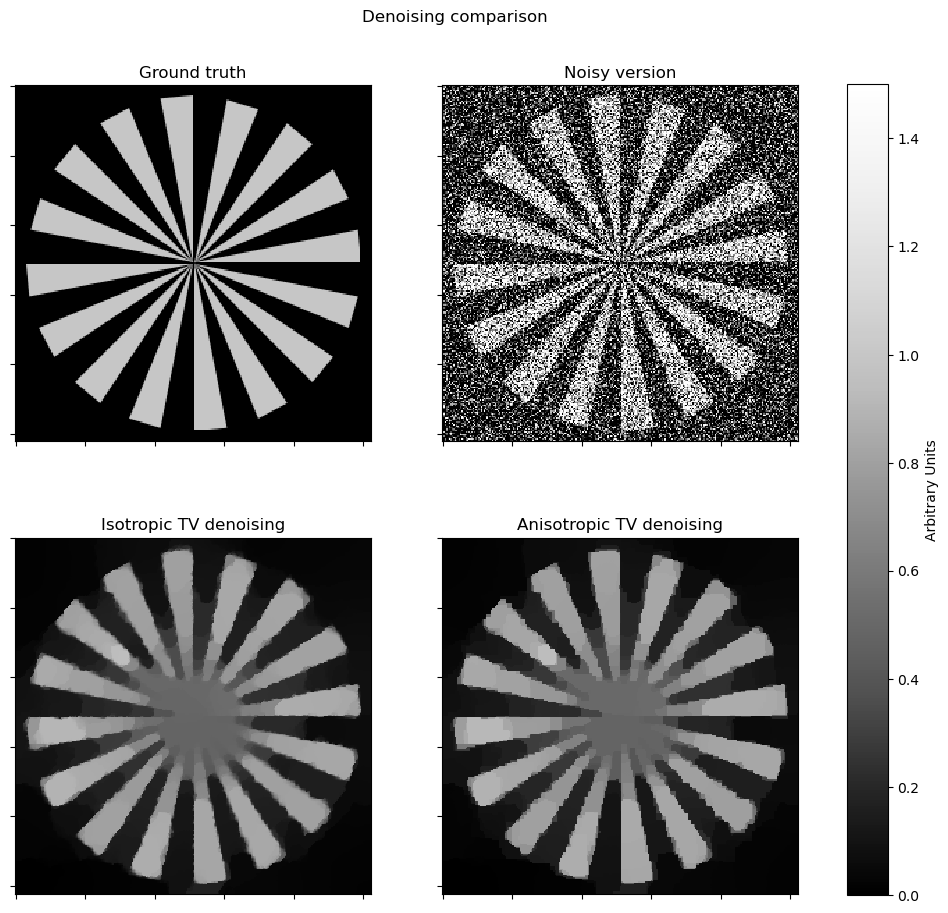

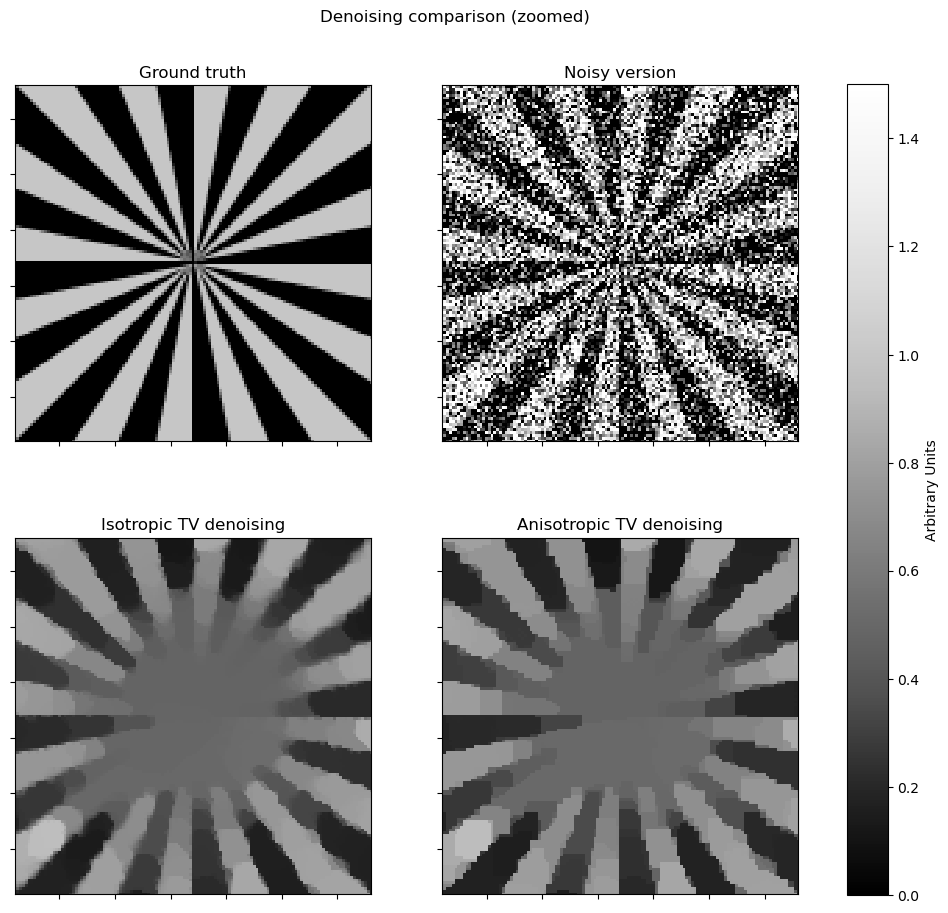

In [7]:
plt_args = dict(norm=plot.matplotlib.colors.Normalize(vmin=0, vmax=1.5))
fig, ax = plot.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(11, 10))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0, 0], **plt_args)
plot.imview(y, title="Noisy version", fig=fig, ax=ax[0, 1], **plt_args)
plot.imview(x_iso, title="Isotropic TV denoising", fig=fig, ax=ax[1, 0], **plt_args)
plot.imview(x_aniso, title="Anisotropic TV denoising", fig=fig, ax=ax[1, 1], **plt_args)
fig.subplots_adjust(left=0.1, right=0.99, top=0.95, bottom=0.05, wspace=0.2, hspace=0.01)
fig.colorbar(
    ax[0, 0].get_images()[0], ax=ax, location="right", shrink=0.9, pad=0.05, label="Arbitrary Units"
)
fig.suptitle("Denoising comparison")
fig.show()

# zoomed version
fig, ax = plot.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(11, 10))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0, 0], **plt_args)
plot.imview(y, title="Noisy version", fig=fig, ax=ax[0, 1], **plt_args)
plot.imview(x_iso, title="Isotropic TV denoising", fig=fig, ax=ax[1, 0], **plt_args)
plot.imview(x_aniso, title="Anisotropic TV denoising", fig=fig, ax=ax[1, 1], **plt_args)
ax[0, 0].set_xlim(N // 4, N // 4 + N // 2)
ax[0, 0].set_ylim(N // 4, N // 4 + N // 2)
fig.subplots_adjust(left=0.1, right=0.99, top=0.95, bottom=0.05, wspace=0.2, hspace=0.01)
fig.colorbar(
    ax[0, 0].get_images()[0], ax=ax, location="right", shrink=0.9, pad=0.05, label="Arbitrary Units"
)
fig.suptitle("Denoising comparison (zoomed)")
fig.show()

